In [1]:
%load_ext autoreload

In [89]:
import math
import os
import pprint
import time
import torch

In [83]:
from cora_data import CoraData
from gcn import NodeClassifier
from train import run_one_epoch
from graph_sampling import get_unique_nodes

In [84]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [4]:
torch.__version__

'1.9.0'

In [5]:
data_root = os.path.join(os.path.expanduser('~/ml_datasets/'), 'cora')
val_frac = 0.15
test_frac = 0.15
data = CoraData(data_root, val_frac, test_frac)

In [6]:
total_nodes = get_unique_nodes(data.adjList)
V = len(total_nodes)

In [7]:
print(f'input feature dimension: {data.features.shape[1]}')
print(f'num of train nodes: {len(data.train_nodes)}, validation nodes: {len(data.val_nodes)}, test nodes: {len(data.test_nodes)}')


input feature dimension: 1433
num of train nodes: 1905, validation nodes: 417, test nodes: 386


In [8]:
embeddings = torch.nn.Embedding(
    num_embeddings=data.features.shape[0],
    embedding_dim=data.features.shape[1]
)
embeddings.weight = torch.nn.Parameter(torch.from_numpy(data.features))
embeddings.weight.requires_grad = False

In [100]:
# Specify configs

# Data
num_classes = len(data.class2id)
input_dim = data.features.shape[1]

# Training parameters
num_epochs = 40
batch_size = 256
learning_rate = 0.03

# GCN parameters
k_layers = 2
num_neighbors = 10
topK = 10
dims = [input_dim, input_dim, 2*input_dim, 512, 
        512, 512, 2*512, 256
       ]
output_dim = 256
n_iters = 10
n_hops = 7


config_dict = {
    'num_classes': num_classes,
    'input_dim': input_dim,
    'V': V,
    'num_epochs': num_epochs,
    'batch_size': batch_size,
    'learning_rate': learning_rate,
    'k_layers': k_layers,
    'num_neighbors': num_neighbors,
    'topK': topK,
    'dims': dims,
    'output_dim': output_dim,
    'n_iters': n_iters,
    'n_hops': n_hops
}

In [101]:
def make_model(config_dict):
    
    model = NodeClassifier(
        num_classes=config_dict['num_classes'], 
        dims=config_dict['dims'], 
        k_layers=config_dict['k_layers'], 
        output_dim=config_dict['output_dim']
    )

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=config_dict['learning_rate']
    )

    loss_func = torch.nn.CrossEntropyLoss()
    
    return model, optimizer, loss_func

In [102]:
def train_model(config_dict, sampling_method):
    
    model, optimizer, loss_func = make_model(config_dict)
    
    train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []
    
    for epoch_idx in range(config_dict['num_epochs']):
        
        if (1 + epoch_idx) % 5 == 0:
            print(f'epoch: {epoch_idx}')
        
        model.train()
        train_loss, train_acc = run_one_epoch(
            model, 
            optimizer, 
            loss_func, 
            V,
            data.train_nodes,
            data.adjList,
            data.labels,
            embeddings,
            config_dict['k_layers'],
            config_dict['num_neighbors'],
            config_dict['topK'],
            config_dict['batch_size'],
            sampling_method,
            config_dict['n_iters'],
            config_dict['n_hops'],
            True            
        )
              
        model.eval()    
        val_loss, val_acc = run_one_epoch(
            model, 
            None, 
            loss_func, 
            V,
            data.val_nodes,
            data.adjList,
            data.labels,
            embeddings,
            config_dict['k_layers'],
            config_dict['num_neighbors'],
            config_dict['topK'],
            config_dict['batch_size'],
            sampling_method,
            config_dict['n_iters'],
            config_dict['n_hops'],
            False
        )        
        
        # record metrics
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)
        
    # final evaluation
    model.eval()
    test_loss, test_acc = run_one_epoch(
        model,
        None,
        loss_func,
        V,
        data.test_nodes,
        data.adjList,
        data.labels,
        embeddings,
        config_dict['k_layers'],
        config_dict['num_neighbors'],
        config_dict['topK'],
        config_dict['batch_size'],
        sampling_method,
        config_dict['n_iters'],
        config_dict['n_hops'],
        False        
    )
        
    results = {
        'model': model,
        'optimizer': optimizer,
        'train_loss_list': train_loss_list,
        'train_acc_list': train_acc_list,
        'val_loss_list': val_loss_list,
        'val_acc_list': val_acc_list,
        'test_loss': test_loss,
        'test_acc': test_acc
    }
    
    return results
    

In [ ]:
start_time = time.time()
result1 = train_model(config_dict, 'topK')
time_elapsed = time.time() - start_time
print(f'time elapsed: {time_elapsed}')

In [ ]:
start_time = time.time()
result2 = train_model(config_dict, 'random')
time_elapsed = time.time() - start_time
print(f'time elapsed: {time_elapsed}')

In [98]:
def adjust_axes(ax, fontsize, x_rotation=0, y_rotation=0):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
        tick.label.set_rotation(x_rotation)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
        tick.label.set_rotation(y_rotation)        

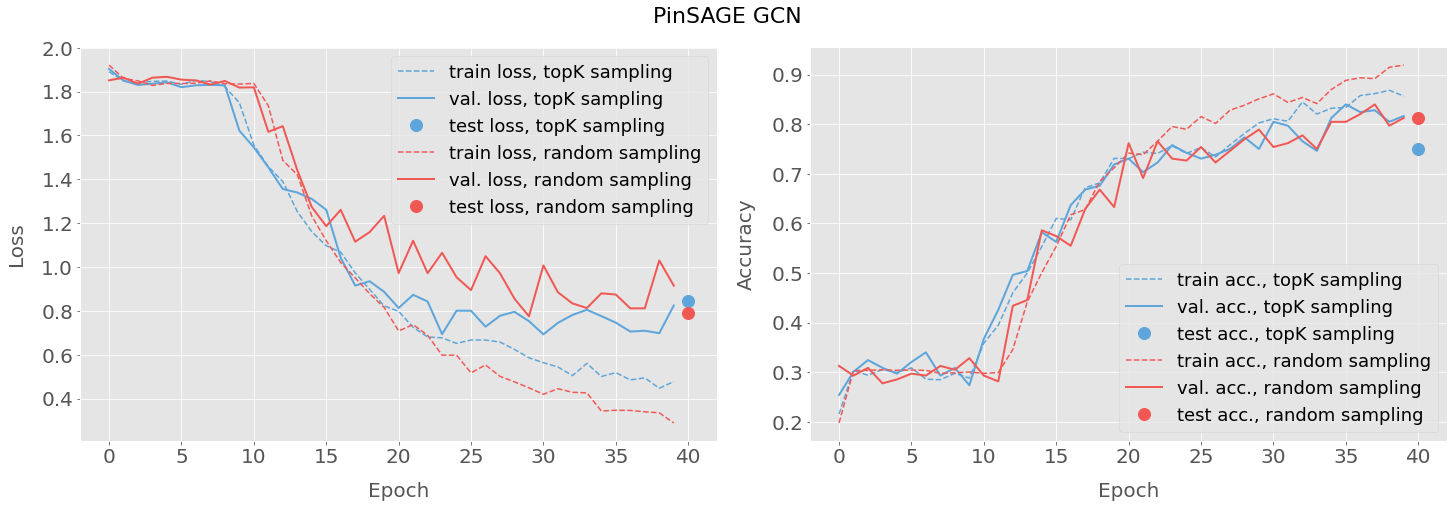

In [106]:
fontsize = 20
plt.close('all')
fig = plt.figure(figsize=(20, 7))
gs = matplotlib.gridspec.GridSpec(1, 2)

blue = '#5DA5DA'
red = '#F15854'

ax = plt.subplot(gs[0, 0])
ax.plot(result1['train_loss_list'], color=blue, ls='--', lw=1.5, label='train loss, topK sampling')
ax.plot(result1['val_loss_list'], color=blue, ls='-', lw=2, label='val. loss, topK sampling')
ax.plot(len(result1['val_loss_list']), result1['test_loss'], color=blue, ls='', marker='o', markersize=12, label='test loss, topK sampling')

ax.plot(result2['train_loss_list'], color=red, ls='--', lw=1.5, label='train loss, random sampling')
ax.plot(result2['val_loss_list'], color=red, ls='-', lw=2, label='val. loss, random sampling')
ax.plot(len(result2['val_loss_list']), result2['test_loss'], color=red, ls='', marker='o', markersize=12, label='test loss, random sampling')

ax.set_xlabel('Epoch', fontsize=fontsize, labelpad=15)
ax.set_ylabel('Loss', fontsize=fontsize, labelpad=15)
adjust_axes(ax, fontsize)
xticks_position = list(range(0, len(result1['train_loss_list'])+1, 5))
_ = ax.set_xticks(xticks_position)

ax.legend(loc='best', fontsize=18)


ax = plt.subplot(gs[0, 1])
ax.plot(result1['train_acc_list'], color=blue, ls='--', lw=1.5, label='train acc., topK sampling')
ax.plot(result1['val_acc_list'], color=blue, ls='-', lw=2, label='val. acc., topK sampling')
ax.plot(len(result1['val_acc_list']), result1['test_acc'], color=blue, ls='', marker='o', markersize=12, label='test acc., topK sampling')

ax.plot(result2['train_acc_list'], color=red, ls='--', lw=1.5, label='train acc., random sampling')
ax.plot(result2['val_acc_list'], color=red, ls='-', lw=2, label='val. acc., random sampling')
ax.plot(len(result2['val_acc_list']), result2['test_acc'], color=red, ls='', marker='o', markersize=12, label='test acc., random sampling')

ax.set_xlabel('Epoch', fontsize=fontsize, labelpad=15)
ax.set_ylabel('Accuracy', fontsize=fontsize, labelpad=15)
adjust_axes(ax, fontsize)
xticks_position = list(range(0, len(result2['train_acc_list'])+1, 5))
_ = ax.set_xticks(xticks_position)

ax.legend(loc='best', fontsize=18)



plt.tight_layout(pad=0, w_pad=2.0, h_pad=0)
fig.suptitle('PinSAGE GCN', fontsize=1.1*FONTSIZE)
plt.subplots_adjust(top=0.9)
